# Tutorial Assignment 2

In [1]:
import os

import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics  # use existing libraries!

In [1008]:
!pip install bioinfokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 590.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.0-py3-none-any.whl size=58648 sha256=9cbf244cc640eef6676ccbae71f6f06922b726c36e43b2ed8726f22fe36dedff
  Stored in directory: /Users/blue/Library/Caches/pip/wheels/c9/ab/ed/8a7fde0a63653b75ac029d67598265d185e5915dfb594ddc59
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7074 sha256=b801b0bee077aae3de2f6c563961a690087c9233df34cf69d3ed5ec6a7080ab9
  Stored in directory: /Users/blue/Library/Caches/pip/wheels/6b/1d/79/4326d5f3a7d86fb9900e5564e7a0f98b552da5103ca762f24f
  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.7-py3-none-any.whl size=32155 sha256=6f51de0b2b652fe3127ee6eede5c947b3f017cb5ab0dfab8933a414314db1efe
  Stored in directory: /Users/blue/Library/Caches/pip/wheels/

In [2]:
# score function: binary cross entropy loss
def score_yp(y, p): # y, p are numpy arrays
    return sklearn.metrics.log_loss(y, p)

In [3]:
# score wrapper, for data frames. we need this when using the `truth` data frame
def score(x, y): # x, y are data frames
    xy = pd.merge(x, y, on=["customer", "product", "week"])
    assert xy.shape[0] == x.shape[0]
    return score_yp(xy["y"].values, xy["probability"].values)

## Input

In [853]:
# INPUT
training_week = 70  # for model training
validation_week = 71  # for model and baseline validation
test_week = 90  # for the final prediction (one week in the future, beyond our data)
target_customers = list(range(2000))
target_products = list(range(250))

## Load data

In [6]:
baskets = pd.read_parquet(f"/Users/blue/Downloads/baskets-s.parquet")
# we only keep the 2000 customers required for the test set
# a complex model might require more data, e.g., see Boosted Tree model in Gabel & Timoshenko (2021)
baskets.head()

,week,customer,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592


In [ ]:
#check if there's missing data

In [964]:
baskets.isnull().values.any()

False

In [7]:
prediction_index = pd.read_parquet(f"/Users/blue/Downloads/prediction_index.parquet")
prediction_index.head()

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4


In [659]:
coupon = pd.read_parquet(f"/Users/blue/Downloads/coupons-s.parquet")
coupon.head()

,week,customer,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30


In [965]:
coupon.isnull().values.any()

False

In [660]:
coupon

,week,customer,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44509995,89,1999,108,10
44509996,89,1999,207,25
44509997,89,1999,246,30
44509998,89,1999,51,15


In [177]:
#create a new basket dataset for calculate basket purchase with discount
baskets_wdiscounts = pd.read_parquet(f"/Users/blue/Downloads/baskets-s.parquet")
baskets_wdiscounts = baskets_wdiscounts.drop('price', axis=1)
baskets_wdiscounts

,week,customer,product
0,0,0,71
1,0,0,91
2,0,0,116
3,0,0,123
4,0,0,157
...,...,...,...
68091869,89,1999,144
68091870,89,1999,158
68091871,89,1999,192
68091872,89,1999,213


In [661]:
#drop discount role in coupon so to merge
coupon_wdiscounts = coupon.drop('discount', axis=1)
coupon_wdiscounts

,week,customer,product
0,0,0,35
1,0,0,193
2,0,0,27
3,0,0,177
4,0,0,5
...,...,...,...
44509995,89,1999,108
44509996,89,1999,207
44509997,89,1999,246
44509998,89,1999,51


In [662]:
baskets_wdiscounts= pd.merge(coupon_wdiscounts, baskets_wdiscounts, how='inner')

In [663]:
baskets_wdiscounts #purchase history with discount

,week,customer,product
0,0,5,221
1,0,7,61
2,0,8,74
3,0,9,194
4,0,11,245
...,...,...,...
54242,89,1989,228
54243,89,1991,75
54244,89,1994,148
54245,89,1994,46


In [672]:
#create another baskeet dataset for calculating interpurchase time
#diff refers to the interpurhcase time (weeks) compare to previous purchase

baskets_wdiff = pd.read_parquet(f"/Users/blue/Downloads/baskets-s.parquet")
baskets_wdiff = baskets_wdiff.drop('price', axis=1)
baskets_wdiff['diff'] = baskets_wdiff.groupby(['customer', 'product'])['week'].diff().fillna(0)
baskets_wdiff

,week,customer,product,diff
0,0,0,71,0.0
1,0,0,91,0.0
2,0,0,116,0.0
3,0,0,123,0.0
4,0,0,157,0.0
...,...,...,...,...
68091869,89,1999,144,1.0
68091870,89,1999,158,1.0
68091871,89,1999,192,1.0
68091872,89,1999,213,5.0


In [ ]:
#validation of the created dataset

In [673]:
baskets_wdiff.loc[(baskets_wdiff['week'] == 3) & (baskets_wdiff['customer'] == 0)]

,week,customer,product,diff
2294602,3,0,71,1.0
2294603,3,0,91,1.0
2294604,3,0,123,3.0
2294605,3,0,130,1.0
2294606,3,0,179,0.0
2294607,3,0,184,1.0
2294608,3,0,214,0.0
2294609,3,0,225,2.0


In [674]:
baskets_wdiff.loc[(baskets_wdiff['product'] == 71 ) & (baskets_wdiff['customer'] == 0)]

,week,customer,product,diff
0,0,0,71,0.0
764812,1,0,71,1.0
1530319,2,0,71,1.0
2294602,3,0,71,1.0
3824161,5,0,71,2.0
...,...,...,...,...
63488993,83,0,71,1.0
64253690,84,0,71,1.0
65018515,85,0,71,1.0
66547264,87,0,71,2.0


## Reminder

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/time-split.png" width="900"/>

## Some first steps

In [665]:
baskets_wdiff.loc[(baskets_wdiff['week']== 5) & (baskets_wdiff['customer']== 0)]

,week,customer,product,diff
3824161,5,0,71,2.0
3824162,5,0,91,1.0
3824163,5,0,122,NaN
3824164,5,0,130,2.0
3824165,5,0,157,4.0
3824166,5,0,202,NaN
3824167,5,0,225,1.0
3824168,5,0,244,NaN


In [17]:
baskets.week.max()

89

In [18]:
n_weeks = baskets.week.nunique()
print(n_weeks)

90


In [19]:
# purchase frequency for one customer and product
(
    baskets[(baskets["customer"]==0) & (baskets["product"]==4)]
    .week.count()
    / n_weeks
)

8

In [256]:
# this is our first "model" – wow, that's easy!
purchase_frequency_ij = (
    (
        baskets.groupby(["customer", "product"])
        [["week"]].count()
        / n_weeks
    )
    .rename(columns={"week": "probability"})
    .reset_index()
)
purchase_frequency_ij

,customer,product,probability
0,0,4,0.088889
1,0,11,0.100000
2,0,15,0.011111
3,0,16,0.044444
4,0,21,0.011111
...,...,...,...
142059,1999,237,0.044444
142060,1999,242,0.388889
142061,1999,243,0.011111
142062,1999,245,0.133333


In [12]:
test_week

90

In [13]:
# add all missing values
# Q1: what values are missing?
# Q2: what is a good value for probabilities here?
df = pd.DataFrame(
    {
        "week": test_week,
        "customer": np.repeat(target_customers, len(target_products), axis=0),
        "product": target_products * len(target_customers),
    }
)
df

,week,customer,product
0,90,0,0
1,90,0,1
2,90,0,2
3,90,0,3
4,90,0,4
...,...,...,...
499995,90,1999,245
499996,90,1999,246
499997,90,1999,247
499998,90,1999,248


In [14]:
result_baseline = pd.merge(
    df,
    purchase_frequency_ij,
    on=["customer", "product"],
    how="left",
).fillna(0)
result_baseline

,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889
...,...,...,...,...
499995,90,1999,245,0.133333
499996,90,1999,246,0.000000
499997,90,1999,247,0.000000
499998,90,1999,248,0.000000


<br>

## SOLUTION 1: Descriptive feature (past purchase rates) = Baseline

Now we have predictions, but we have no idea how good this baseline is.  So let's do the following:
1. construct a ground truth data set
1. do a proper train/validation split
1. predict purchase probabilities using our baseline
1. evaluate the predictions vs. the base

### Validation

In [197]:
# function to define target variable for all customer-product combinations (in a given week)
def build_target(baskets, week):

    baskets_week = baskets[baskets["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [16]:
validation_week

89

In [17]:
baseline_target = build_target(baskets, validation_week)
baseline_target.head()

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0


In [18]:
baseline_target.describe()

,week,customer,product,y
count,500000.0,500000.000000,500000.000000,500000.000000
mean,89.0,999.500000,124.500000,0.030386
std,0.0,577.350774,72.168278,0.171647
min,89.0,0.000000,0.000000,0.000000
25%,89.0,499.750000,62.000000,0.000000
50%,89.0,999.500000,124.500000,0.000000
75%,89.0,1499.250000,187.000000,0.000000
max,89.0,1999.000000,249.000000,1.000000


In [19]:
# the perfect prediction has a loss of 0
score_yp(baseline_target.y.values, baseline_target.y.values)

9.99200722162641e-16

In [20]:
# wrap code into function:
# baseline = purchase rates for customer-product combinations before the target week
def baseline_prediction(baskets, week):

    # subset baskets
    baskets_t = baskets[baskets["week"] < week].reset_index(drop=True)
    n_weeks = baskets_t.week.nunique()
    print(n_weeks)

    # model (non-0 probabilities)
    purchase_frequency_ij = (
        (baskets_t.groupby(["customer", "product"])[["week"]].count() / n_weeks)
        .rename(columns={"week": "probability"})
        .reset_index()
    )

    # filling in 0s
    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    result_baseline = pd.merge(
        df,
        purchase_frequency_ij,
        on=["customer", "product"],
        how="left",
    ).fillna(0)

    return result_baseline

In [21]:
# prediction for validation data
baseline_validation = baseline_prediction(baskets, validation_week)
baseline_validation.head()

89


,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888


In [22]:
baseline_target

,week,customer,product,y
0,89,0,0,0
1,89,0,1,0
2,89,0,2,0
3,89,0,3,0
4,89,0,4,0
...,...,...,...,...
499995,89,1999,245,1
499996,89,1999,246,0
499997,89,1999,247,0
499998,89,1999,248,0


In [23]:
baseline_validation

,week,customer,product,probability
0,89,0,0,0.000000
1,89,0,1,0.000000
2,89,0,2,0.000000
3,89,0,3,0.000000
4,89,0,4,0.089888
...,...,...,...,...
499995,89,1999,245,0.123596
499996,89,1999,246,0.000000
499997,89,1999,247,0.000000
499998,89,1999,248,0.000000


In [24]:
# score for validation data
score(baseline_target, baseline_validation)

0.10034939532139737

### Test

In [25]:
validation_week + 1

90

In [26]:
test_week

90

In [27]:
# prediction for test data
# we can't evaluate this
baseline_test = baseline_prediction(baskets, test_week)
baseline_test.head()

90


,week,customer,product,probability
0,90,0,0,0.000000
1,90,0,1,0.000000
2,90,0,2,0.000000
3,90,0,3,0.000000
4,90,0,4,0.088889


Conclusion:
1. Train model to week 88, evaluate predictions for week 89 with truth data 
1. Predict week 90, and submit

<br>

## SOLUTION 2: simple machine learning model   

### Example for constructing the features

In [806]:
def build_frequency_feature(baskets, week_start, week_end, feature_name):
    # subset baskets
    baskets_subset = baskets[
        (baskets["week"] >= week_start) & (baskets["week"] <= week_end)
    ]
    print(baskets_subset.week.nunique())

    purchase_frequency_ij = (
        (
            baskets_subset.groupby(["customer", "product"])[["week"]].count()
            / baskets_subset.week.nunique()
        )
        .rename(columns={"week": feature_name})
        .reset_index()
    )

    return purchase_frequency_ij

In [807]:
def build_coupon_offer_feature(coupon, week_start, week_end, feature_name):
    coupon_subset = coupon[
        (coupon["week"] >= week_start) & (coupon["week"] <= week_end)
    ]
    print(coupon_subset.week.nunique())
    
    coupon_offer_frequency_ij = (
        (
            coupon_subset.groupby(["customer", "product"])[["week"]].count()
        )
        .rename(columns={"week": feature_name})
        .reset_index()
    )

    return coupon_offer_frequency_ij

In [808]:
def build_coupon_used_feature(baskets_wdiscounts, week_start, week_end, feature_name):
    baskets_wdiscounts_subset = baskets_wdiscounts[
        (baskets_wdiscounts["week"] >= week_start) & (baskets_wdiscounts["week"] <= week_end)
    ]
    print(baskets_wdiscounts_subset.week.nunique())
    
    coupon_used_frequency_ij = (
        (
            baskets_wdiscounts_subset.groupby(["customer", "product"])[["week"]].count()
        )
        .rename(columns={"week": feature_name})
        .reset_index()
    )

    return coupon_used_frequency_ij

In [812]:
def build_price_feature(baskets, week_start, week_end, feature_name):
    baskets_subset = baskets[
        (baskets["week"] >= week_start) & (baskets["week"] <= week_end)
    ]
    print(baskets_subset.week.nunique())
    
    total_price_ij = (
        (
            baskets_subset.groupby(["customer", "product"])[["price"]].sum()
        )
        .rename(columns={"price": feature_name})
        .reset_index()
    )
    return total_price_ij

In [813]:
def build_avgprice_feature(baskets, week_start, week_end, feature_name):
    baskets_subset = baskets[
        (baskets["week"] >= week_start) & (baskets["week"] <= week_end)
    ]
    print(baskets_subset.week.nunique())
    
    avg_price_ij = (
        (
            baskets_subset.groupby(["customer", "product"])[["price"]].mean()
        #rescale the price by dividing by 100
        )
        .rename(columns={"price": feature_name})
        .reset_index()
    )
    return avg_price_ij

In [811]:
def build_interpurchasetime_feature(baskets, week_start, week_end, feature_name):
    baskets_wdiff_subset = baskets_wdiff[
        (baskets_wdiff["week"] >= week_start) & (baskets_wdiff["week"] <= week_end)
    ]
    print(baskets_wdiff_subset.week.nunique())
    
    median_interpurchasetime_ij = (
        (
            baskets_wdiff_subset.groupby(["customer", "product"])[["diff"]].median()
            
        )
        .rename(columns={"diff": feature_name})
        .reset_index()
    )
    return median_interpurchasetime_ij

In [ ]:
#validation of the build interpurchase time function

In [814]:
test= build_interpurchasetime_feature( baskets, -1, training_week -1, "median of interpurchase time")
test

50


,customer,product,median of interpurchase time
0,0,4,5.0
1,0,11,10.0
2,0,15,0.0
3,0,16,5.0
4,0,37,0.0
...,...,...,...
120126,1999,237,18.5
120127,1999,242,2.0
120128,1999,243,0.0
120129,1999,245,5.0


In [815]:
test.loc[(test['product'] == 71  ) & (test['customer'] == 0)]

,customer,product,median of interpurchase time
12,0,71,1.0


In [816]:
build_avgprice_feature ( baskets, -1, training_week -1, "average money spent")

50


,customer,product,average money spent
0,0,4,620.000000
1,0,11,611.000000
2,0,15,620.000000
3,0,16,644.000000
4,0,37,772.000000
...,...,...,...
120126,1999,237,466.000000
120127,1999,242,505.866667
120128,1999,243,490.000000
120129,1999,245,533.285714


In [817]:
build_price_feature ( baskets, -1, training_week -1, "total money spent")

50


,customer,product,total money spent
0,0,4,1860
1,0,11,1833
2,0,15,620
3,0,16,1932
4,0,37,772
...,...,...,...
120126,1999,237,932
120127,1999,242,7588
120128,1999,243,490
120129,1999,245,3733


In [818]:
build_coupon_used_feature ( baskets_wdiscounts, -1, training_week -1 , "number of redeemed discouont")

50


,customer,product,number of redeemed discouont
0,0,16,1
1,0,67,1
2,0,71,1
3,0,116,1
4,0,184,1
...,...,...,...
25174,1999,224,1
25175,1999,228,1
25176,1999,242,1
25177,1999,245,2


In [819]:
build_coupon_feature ( coupon, -1, training_week -1 , "number of discount offer")

50


,customer,product,number of discount offer
0,0,2,2
1,0,3,1
2,0,4,3
3,0,5,2
4,0,7,3
...,...,...,...
317613,1999,244,2
317614,1999,245,3
317615,1999,246,1
317616,1999,247,1


In [820]:
build_frequency_feature(baskets, -1, training_week - 1, "frequency_full")

50


,customer,product,frequency_full
0,0,4,0.06
1,0,11,0.06
2,0,15,0.02
3,0,16,0.06
4,0,37,0.02
...,...,...,...
120126,1999,237,0.04
120127,1999,242,0.30
120128,1999,243,0.02
120129,1999,245,0.14


### Example for building the base table

In [894]:
def build_base_table(baskets, week):
    # target variable (product purchase)
    # consider using multiple weeks for training! more data might lead to better results.
    # also, different weeks might have different information.
    y = build_target(baskets, week)
    # features
    # note how features are computed on data BEFORE the target week
    x_1 = build_frequency_feature(baskets, -1, week - 1, "frequency_full")
    x_2 = build_frequency_feature(baskets, week - 20, week - 1, "frequency_l20")
    x_3 = build_frequency_feature(baskets, week - 10, week - 1, "frequency_l10")
    x_4 = build_frequency_feature(baskets, week - 5, week - 1, "frequency_l5")
    x_5 = build_frequency_feature(baskets, week - 4, week - 1, "frequency_l4")
    x_6 = build_frequency_feature(baskets, week - 3, week - 1, "frequency_l3")
    x_7 = build_frequency_feature(baskets, week - 2, week - 1, "frequency_l2")
    x_8 = build_coupon_feature (coupon, -1, week -1 , "number of discount offer")
    x_9 = build_coupon_used_feature ( baskets_wdiscounts, -1, week -1 , "number of redeemed discouont")
    x_10 = build_price_feature ( baskets, -1, week -1, "total money spent")
    x_11 = build_avgprice_feature (baskets, -1, week - 1, "average money spent")
    x_12 = build_interpurchasetime_feature(baskets, -1, week -1, "median of interpurchase time")
    base_table_yx = (
        y.merge(x_1, on=["customer", "product"], how="left")
        .merge(x_2, on=["customer", "product"], how="left")
        .merge(x_3, on=["customer", "product"], how="left")
        .merge(x_4, on=["customer", "product"], how="left")
        .merge(x_5, on=["customer", "product"], how="left")
        .merge(x_6, on=["customer", "product"], how="left")
        .merge(x_7, on=["customer", "product"], how="left")
        .merge(x_8, on=["customer", "product"], how="left")
        .merge(x_9, on=["customer", "product"], how="left")
        .merge(x_10, on=["customer", "product"], how="left")
        .merge(x_11, on=["customer", "product"], how="left")
        .merge(x_12, on=["customer", "product"], how="left")
        .fillna(0)
    )
    return base_table_yx

###### build_base_table(baskets, training_week)

### Training: Train model (week < 89)

In [1125]:
training_week = 70  # for model training
validation_week = 71  # for model and baseline validation

In [1126]:
base_table_train = build_base_table(baskets, training_week)

70
20
10
5
4
3
2
70
70
70
70
70


In [993]:
base_table_train

,week,customer,product,y,frequency_full,frequency_l20,frequency_l10,frequency_l5,frequency_l4,frequency_l3,frequency_l2,number of discount offer,number of redeemed discouont,total money spent,average money spent,median of interpurchase time
0,88,0,0,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,88,0,1,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0
2,88,0,2,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0
3,88,0,3,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0
4,88,0,4,0,0.090909,0.05,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4960.0,620.00,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,88,1999,245,0,0.125000,0.05,0.0,0.0,0.0,0.0,0.0,4.0,2.0,5929.0,539.00,4.0
499996,88,1999,246,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0
499997,88,1999,247,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.00,0.0
499998,88,1999,248,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0


In [1127]:
y = base_table_train["y"].values  # 1s and 0s

In [ ]:
#full list of variablese
#"frequency_full", "frequency_l20", "frequency_l10", "frequency_l5", "frequency_l4",
#"frequency_l3", "frequency_l2", "number of discount offer", "number of redeemed discouont", 
#"average money spent","total money spent","median of interpurchase time"

In [1070]:
X = base_table_train[[ "frequency_full", "frequency_l20","frequency_l10", "frequency_l5", 
                      "frequency_l4", "frequency_l3","frequency_l2",
                      "number of discount offer", "number of redeemed discouont", 
                      "average money spent","total money spent",
                      "median of interpurchase time"]].values  # purchase frequencies & discounts

In [1145]:
log_reg = sklearn.linear_model.LogisticRegression(max_iter= 500).fit(X, y)

In [1146]:
log_reg.intercept_, log_reg.coef_

(array([-5.92661642]),
 array([[ 8.14940824e-02,  2.91179032e-01,  4.74518839e-03,
          2.25724782e-03,  5.28194161e-03,  6.73010528e-03,
          9.81946978e-03, -5.95699665e-02,  2.73165770e-01,
          3.99701381e-03,  1.28066305e-04,  1.78566202e-02]]))

In [1147]:
# use model to predict purchase probabilities 
base_table_train["probability"] = log_reg.predict_proba(X)[:, 1]

In [1061]:
base_table_train

,week,customer,product,y,frequency_full,frequency_l20,frequency_l10,frequency_l5,frequency_l4,frequency_l3,frequency_l2,number of discount offer,number of redeemed discouont,total money spent,average money spent,median of interpurchase time,probability
0,88,0,0,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.004134
1,88,0,1,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003478
2,88,0,2,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003478
3,88,0,3,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003478
4,88,0,4,0,0.090909,0.05,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4960.0,620.00,4.5,0.050714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,88,1999,245,0,0.125000,0.05,0.0,0.0,0.0,0.0,0.0,4.0,2.0,5929.0,539.00,4.0,0.070807
499996,88,1999,246,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003478
499997,88,1999,247,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.00,0.0,0.003189
499998,88,1999,248,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003478


In [1062]:
base_table_train.describe()

,week,customer,product,y,frequency_full,frequency_l20,frequency_l10,frequency_l5,frequency_l4,frequency_l3,frequency_l2,number of discount offer,number of redeemed discouont,total money spent,average money spent,median of interpurchase time,probability
count,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,88.0,999.500000,124.500000,0.030654,0.030641,0.030606,0.030634,0.030648,0.030655,0.030752,0.030733,1.760000,0.106108,1575.630886,165.531328,1.605962,0.030644
std,0.0,577.350774,72.168278,0.172379,0.092854,0.096463,0.101532,0.111131,0.115689,0.123236,0.137237,1.314785,0.412429,4842.252146,269.028386,4.530072,0.092909
min,88.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001739
25%,88.0,499.750000,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.003478
50%,88.0,999.500000,124.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.003792
75%,88.0,1499.250000,187.000000,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,563.000000,470.400000,0.000000,0.022893
max,88.0,1999.000000,249.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,7.000000,69960.000000,837.000000,43.500000,0.998784


In [1148]:
score_yp(
    base_table_train["y"].values,
    base_table_train["probability"].values,
)

0.07978815831633096

### Validation: Test model performance (week 89)

In [1132]:
base_table_validation = build_base_table(baskets, validation_week)

71
20
10
5
4
3
2
71
71
71
71
71


In [1133]:
X_validation = base_table_validation[["frequency_full", "frequency_l20","frequency_l10", "frequency_l5", 
                      "frequency_l4", "frequency_l3","frequency_l2",
                      "number of discount offer", "number of redeemed discouont", 
                      "average money spent","total money spent",
                      "median of interpurchase time"]
].values

In [1149]:
base_table_validation["probability"] = log_reg.predict_proba(X_validation)[:, 1]

In [1083]:
base_table_validation

,week,customer,product,y,frequency_full,frequency_l20,frequency_l10,frequency_l5,frequency_l4,frequency_l3,frequency_l2,number of discount offer,number of redeemed discouont,total money spent,average money spent,median of interpurchase time,probability
0,89,0,0,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.004135
1,89,0,1,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003477
2,89,0,2,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.00,0.0,0.003189
3,89,0,3,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003477
4,89,0,4,0,0.089888,0.05,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4960.0,620.00,4.5,0.050710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,89,1999,245,1,0.123596,0.05,0.0,0.0,0.0,0.0,0.0,4.0,2.0,5929.0,539.00,4.0,0.070801
499996,89,1999,246,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003477
499997,89,1999,247,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.00,0.0,0.003189
499998,89,1999,248,0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.0,0.003477


In [989]:
base_table_validation.describe()

,week,customer,product,y,frequency_full,frequency_l20,frequency_l10,frequency_l5,frequency_l4,frequency_l3,frequency_l2,number of discount offer,number of redeemed discouont,total money spent,average money spent,median of interpurchase time,probability
count,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,82.0,999.500000,124.500000,0.030430,0.030643,0.030600,0.030615,0.03063,0.030666,0.030705,0.030669,1.640000,0.098974,1468.329936,162.350074,1.483779,0.032151
std,0.0,577.350774,72.168278,0.171768,0.092938,0.096525,0.101338,0.11118,0.115706,0.123110,0.136861,1.269521,0.393327,4516.274191,267.393049,4.215632,0.097169
min,82.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061
25%,82.0,499.750000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.003443
50%,82.0,999.500000,124.500000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005684
75%,82.0,1499.250000,187.000000,0.000000,0.012195,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.000000,539.000000,465.000000,0.000000,0.013666
max,82.0,1999.000000,249.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,10.000000,7.000000,65190.000000,837.000000,40.500000,0.998483


In [1150]:
score_yp(
    base_table_validation["y"].values,
    base_table_validation["probability"].values,
)

0.08604335150320082

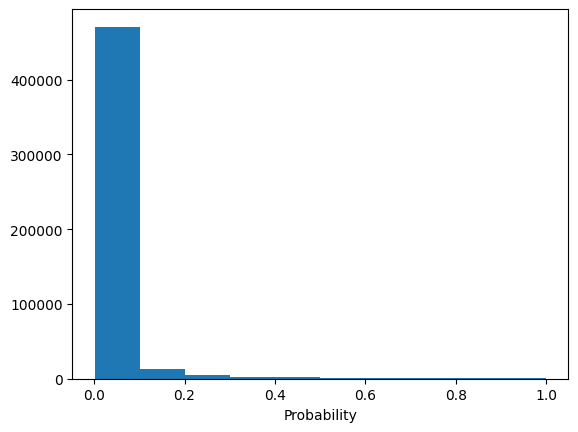

In [945]:
import matplotlib.pyplot as plt

plt.hist(base_table_validation["probability"])
plt.xlabel("Probability")
plt.show()

### Test: Produce final result for submission (week 90)

We can't evaluate this prediction because we don't have this data -- that's why we need the validation set! 

In [858]:
base_table_test = build_base_table(baskets, test_week)

90
20
10
5
4
3
2
90
90
90
90
90


In [860]:
X_test = base_table_test[["frequency_full", "frequency_l20", "frequency_l10","frequency_l5", "frequency_l4",
                      "frequency_l3", "frequency_l2",
                      "number of discount offer", "number of redeemed discouont", "average money spent","total money spent",
                      "median of interpurchase time"]].values

In [914]:
base_table_test["probability"] = log_reg.predict_proba(X_test)[:, 1]

In [915]:
base_table_test

,week,customer,product,y,frequency_full,frequency_l20,frequency_l10,frequency_l5,frequency_l4,frequency_l3,frequency_l2,number of discount offer,number of redeemed discouont,total money spent,average money spent,median of interpurchase time,probability
0,90,0,0,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.004198
1,90,0,1,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,2.0,0.0,0.0,0.000000,0.0,0.003501
2,90,0,2,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,3.0,0.0,0.0,0.000000,0.0,0.003197
3,90,0,3,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,2.0,0.0,0.0,0.000000,0.0,0.003501
4,90,0,4,0,0.088889,0.05,0.0,0.0,0.00,0.000000,0.0,3.0,0.0,4960.0,620.000000,4.5,0.053159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,90,1999,245,0,0.133333,0.10,0.1,0.2,0.25,0.333333,0.5,4.0,2.0,6478.0,539.833333,4.5,0.076053
499996,90,1999,246,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,3.0,0.0,0.0,0.000000,0.0,0.003197
499997,90,1999,247,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,3.0,0.0,0.0,0.000000,0.0,0.003197
499998,90,1999,248,0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,2.0,0.0,0.0,0.000000,0.0,0.003501


<br>

## Score on test set

In real life, never load your test/validation data durnig model training!

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/danger-zone.gif" width="800"/>

In [46]:
# true purchases in week 90
truth = pd.read_parquet(f"{path_truth}/truth.parquet")

In [47]:
score(truth, baseline_test)

0.10008904979918823

In [48]:
score(
    truth,
    base_table_test[["customer", "product", "week", "probability"]],
)

0.08998744561223695

<br>
<br>

<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>